# 2019 Coronavirus analysis


The goal of this analysis is to answer the question "How bad is this going to get?"


I'm applying epidiomilogical theory to try and understand where we are in the covid19 pandemic

(punchline)

In [1]:
from datetime import date

today = date.today()
print("Last ran:", today)

import warnings
warnings.filterwarnings('ignore')


Last ran: 2020-03-16


Starting off with some theory...


### The SIR epidemic model  (susceptible - infectious - recovered)

<img src="model.png">

A classic form of compartmental modeling, the idea is that a population starts off in a particular bucket (either susceptible, infectious, or recovered) and moves into the next bucket at either the transmission rate or the recovery rate.  

  
If you were to plot out the scenario mathematically, it will look like a logistic curve.


Let :
- **t** represent time   in days
- $B$ represent the transmission of the disease
- **$\gamma$** be the average recovery rate from the disease
- ***S(t)*** be the number of people susceptible but not yet infected with the disease 
- ***I(t)*** be the number of of infectious individuals 
- ***R(t)*** are the number of individuals who recovered/removed and are now immune. Note that this includes people who've died

$\frac{dS}{dt}$ = -$\frac{BSI}{N}$   
$\frac{dI}{dt}$ = $\frac{BSI}{N}$ - $\gamma$I   
$\frac{dR}{dt}$ = $\gamma$I   

R0 = $B$/$\gamma$  
(COVID-2019 R0 is estimated to be between 1.4 to 3.8)

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

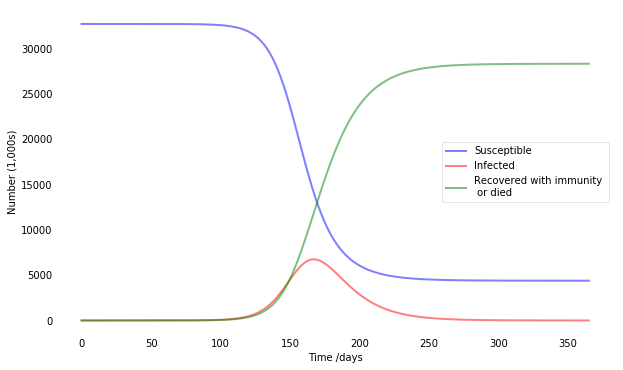

In [3]:
# total population
N = 32700000

# initial number of infected and recovered
I0 = 6
R0 = 0

# everyone else
S0 = N- I0 - R0


#rates (in 1/days)
rnot = 2.32      # estimated to be between 1.4 - 3.8
gamma = 1/14      # time to recovery or death (average of 14 days)
beta = rnot*gamma     # infection rate

# create grid of time points 
days = 365
t = np.linspace(0,days,days)

# differential equations with SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R, = y
    dSdt = -beta*S*I / N
    dIdt = (beta*S*I/N) - gamma*I
    dRdt = gamma*I
    return dSdt, dIdt, dRdt

# create initial conditions vector
y0 = S0, I0, R0

# integration SIR equation over time space
ret = odeint(deriv, y0, t, args=(N,beta,gamma))
S, I, R = ret.T


# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity \n or died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

By plotting out the scenario, we can predict the moment when there is exponential increase in number of people who will be affected by the disease.

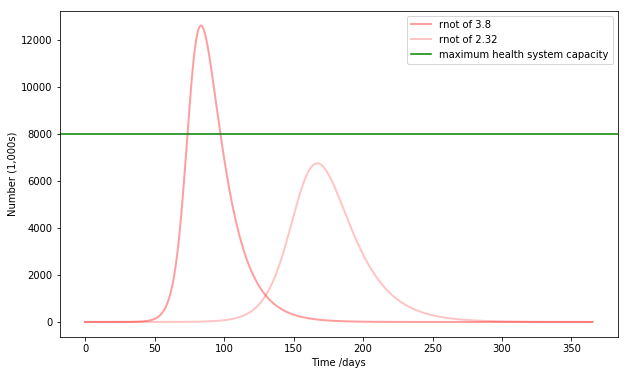

In [4]:
# comparing rnots
rnot_list = [3.8,2.32]
plt.figure(facecolor='w',figsize=(10, 6))

for rnot in rnot_list:
    #rates (in 1/days)
    gamma = 1/14      # time to recovery or death (average of 14 days)
    beta = rnot*gamma     # infection rate

    # create initial conditions vector
    y0 = S0, I0, R0

    # integration SIR equation over time space
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = ret.T


    # Plot the data on three separate curves for I(t)
    plt.plot(t, I/1000, 'r', alpha=rnot/10, lw=2, label='rnot of {}'.format(rnot))
    plt.xlabel('Time /days')
    plt.ylabel('Number (1,000s)')
    
    
plt.axhline(y=8000, label='maximum health system capacity', c='g')
plt.legend()
plt.show()

something about flattening the curve

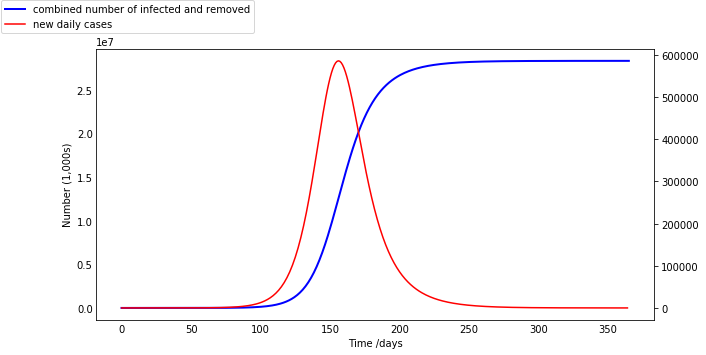

In [24]:
# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 5))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I+R, 'b', alpha=1, lw=2, label='combined number of infected and removed')
# ax.plot(t, S, 'g', alpha=0.5, lw=2, label='S')
# ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity \n or died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

    
y = I + R
y_i = np.gradient(y)

ax2 = ax.twinx()
ax2.plot(y_i, c='r', label='new daily cases')
fig.legend(borderaxespad=0.1, loc='upper left')
plt.show()

  
## Now, looking at the actual data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from scipy import optimize

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

%matplotlib inline



In [7]:
df = pd.read_csv('2019-ncov.csv',index_col=0)

# filling missing date by taking average of the previous and preceding dates
for country in df.columns:
    df[country]['2020-01-22'] = (df[country]['2020-01-21'] + df[country]['2020-01-23'])/2

df['Total_no_china'] = df.loc[:,df.columns != 'China'].sum(axis=1)
df['Total'] = df.loc[:,df.columns != 'Total_no_china'].sum(axis=1)


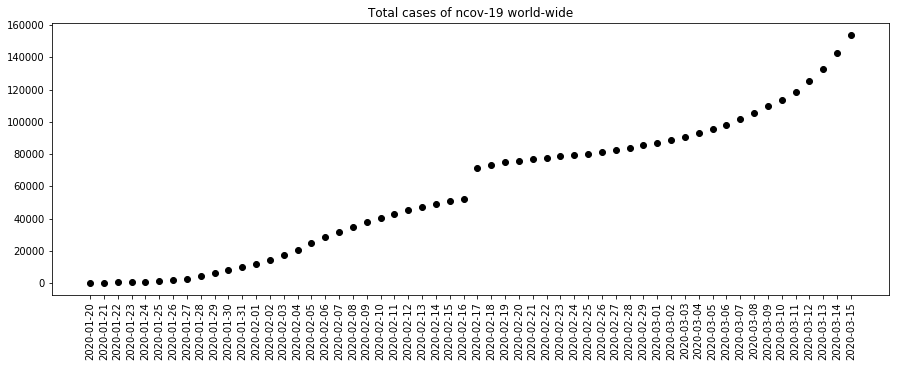

In [8]:
# figure 1
# total cases world wide

plt.figure(figsize=(15,5))

plt.scatter(x=df.index,y=df['Total'], color = 'k')
plt.xticks(rotation=90)
plt.title('Total cases of ncov-19 world-wide')
plt.show()


In [9]:
# 
df.iloc[-1].sort_values(ascending=False).head(n=13)

Total             153530.0
China              81048.0
Total_no_china     72482.0
Italy              21157.0
Iran               12729.0
South Korea         8162.0
Spain               5753.0
France              4469.0
Germany             3795.0
United States       1678.0
Switzerland         1359.0
United Kingdom      1144.0
Netherlands          959.0
Name: 2020-03-15, dtype: float64

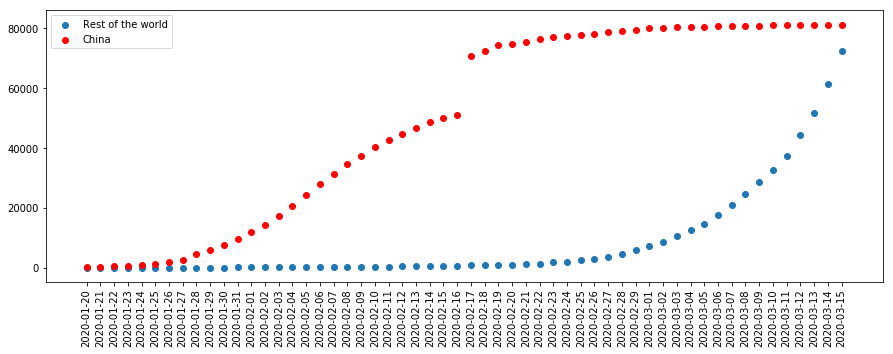

In [10]:
# fig 2
# total cases separating china and the rest of the world

plt.figure(figsize=(15,5))
plt.scatter(x=df.index,y=df['Total_no_china'], label = 'Rest of the world')
plt.scatter(x=df.index,y=df['China'], label='China', color = 'r')
plt.xticks(rotation=90)
plt.legend()
plt.show()

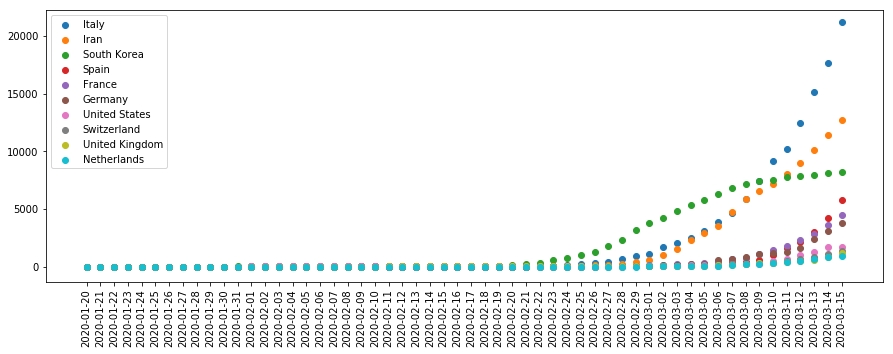

In [11]:
# fig 3
# top six countries (after china) with the highest confirmed cases


plt.figure(figsize=(15,5))

lst = ['Total', 'China', 'Total_no_china']
df2 = df[[c for c in df.columns if c not in lst]]

top10 = df2.iloc[-1].sort_values(ascending=False).head(n=10).index

for country in top10:
    plt.scatter(x=df.index, y=df2[country], label = country)

plt.xticks(rotation=90)
plt.legend()
plt.show()

In [12]:
#guassian function
def fx(x, a,b,c):
    return a*np.exp(-(x-b)**2/(2*(c**2)))

def func(x, w0, w1):
    y = w0 + w1*x
    return np.exp(y)/((1+np.exp(y))**2)

In [13]:
# dividing the countries by region

regions = {
    'china':['China'],
    'western pacific':['South Korea', 'Japan', 'Singapore', 'Malaysia',
                       'Australia','Philippines', 'Vietnam', 'Brunei',
                       'New Zealand', 'Cambodia', 'Mongolia', 'French Polynesia'],
    'european':['Italy', 'France', 'Spain', 'Germany', 'Switzerland', 'Denmark',
                'Netherlands', 'United Kingdom', 'Belgium', 'Austria', 'Norway',
                'Greece', 'Czech Republic', 'Israel', 'San Marino', 'Iceland',
               'Slovenia', 'Romania', 'Poland', 'Ireland', 'Portugal', 'Finland',
                'Georgia', 'Russia', 'Serbia', 'Luxembourg', 'Croatia', 'Latvia',
                'Estonia', 'Hungary', 'Belarus', 'Albania', 'Slovakia', 'Azerbaijan',
                'Bulgaria', 'North Macedonia', 'Cyprus', 'Malta', 'Bosnia and Herzegovina',
               'Moldova', 'Lithuania', 'Andorra', 'Armenia', 'Holy See', 'Liechtenstein',
                'Monaco', 'Turkey', 'Ukraine', 'Faroe Islands', 'Gibraltar', 'Guernsey',
                'Jersey', 'Kazakhstan'],
    'south-east asia':['India', 'Thailand', 'Indonesia', 'Maldives', 'Bangladesh',
                       'Sri Lanka', 'Bhutan', 'Nepal'],
    'eastern mediteranean':['Iran', 'Qatar', 'Bahrain', 'Kuwait', 'United Arab Emirates',
                            'Iraq', 'Egypt', 'Lebanon', 'Saudi Arabia', 'Pakistan', 'Oman',
                            'Afghanistan', 'Tunisia', 'Morocco', 'Jordan', 'Palestine'],
    'americas':['United States', 'Canada', 'Brazil', 'Chile', 'Argentina', 'Ecuador', 
                'Peru', 'Costa Rica', 'Mexico', 'Panama', 'Colombia', 'Dominican Republic',
                'Paraguay', 'Bolivia', 'Honduras', 'Jamaica', 'French Guiana', 'Martinique',
                'Saint Martin', 'Saint Barthelemy', 'Antigua and Barbuda', 'Cayman Islands',
               'Cuba', 'Guadeloupe', 'Guyana', 'Kenya', 'Puerto Rico', 'Saint Vincent',
               'Venezuela', 'Curacao'],
    'african':['Algeria', 'South Africa', 'Senegal', 'Burkina Faso', 'Cameroon', 'Nigeria',
               'Ivory Coast', 'Congo', 'Togo', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea',
              'Reunion', 'Sudan', 'Trinidad and Tobago', 'Namibia', 'Central African Republic',
              'Equatorial Guinea', 'Eswatini', 'Mauritania', 'Mayotte']
       
}

In [14]:
# # plotting by region
# for region, _ in regions.items():
# #     print(region)

#     df_part = df[regions[region]]
#     df_part['total'] = df_part.sum(axis=1)
#     df_part = df_part.loc[df_part['total']>10] #checks for at least 10 cases

#     plt.figure(figsize=(15,5))
#     plt.scatter(x=df_part.index ,y=df_part['total'],c='b', alpha = 0.5)
#     plt.xticks(rotation=90)
#     plt.title('Cumulative total cases for the region of {}'.format(region))
#     plt.show()


#     # taking derivative
#     d1 = df_part['total'].diff()
    
#     if region == 'china':
#         d1.drop(index='2020-02-17', inplace=True)
    
#     plt.figure(figsize=(15,5))
#     plt.scatter(y=d1, x=d1.index, c='k', alpha=0.3)
#     plt.title('Number of new daily cases for the region of {}'.format(region))
#     plt.xticks(rotation=90)

    
#     dd1 = d1.reset_index(drop=True)
#     dd1 = dd1.dropna()
#     X = np.array(dd1.index)#.reshape(-1,1)
#     y = np.array(dd1)#.reshape(-1,1)

    
#     try:
#         # curve
#         params=[0,0,0]
#         bounds = ([50,15,0],[10000,90,20])
#         params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
#         yyy = fx(X,*params)
#         plt.plot(yyy,c='g')
# #         print (params)
        
#         # residuals
#         residuals = y - fx(X,*params)
#         ssres = np.sum(residuals**2)
#         sstot = np.sum((y-np.mean(y))**2)
#         rsquared = 1-(ssres/sstot)
#         print('rsquare: {}'.format(rsquared))
        

#     except:
#         print("no convergence")
#         pass
        
    


#     plt.show()
#     break

rsquare: 0.8685195611761342


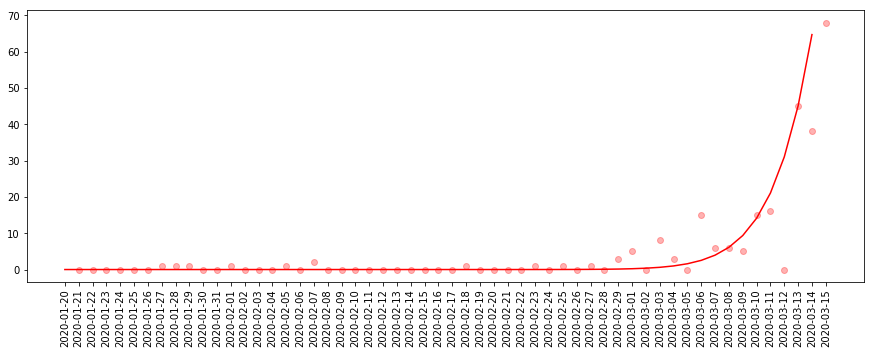

In [15]:

# by specific country

country = 'Canada'

d1 = df[country].diff()
d2 = d1.diff()

plt.figure(figsize=(15,5))
plt.scatter(y=d1, x=d1.index, c='r', alpha=0.3)
plt.xticks(rotation=90)



# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)



# regression
bounds = ([50,15,0],[10000,90,20])
params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
# print(params)

# residuals
residuals = y - fx(X,*params)
ssres = np.sum(residuals**2)
sstot = np.sum((y-np.mean(y))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))
        



# plotting line of best fit
x = np.linspace(0,len(d1)+1,100).reshape(-1,1)
# plt.plot(svr_rbf.fit(X,y).predict(X), c='orange')
plt.plot(fx(X,*params), c='r')




plt.show()

rsquare: 0.9318326567241956


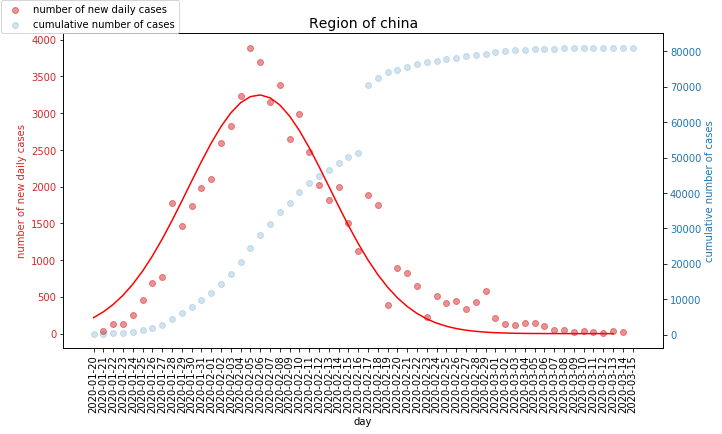

rsquare: 0.8974490520330884


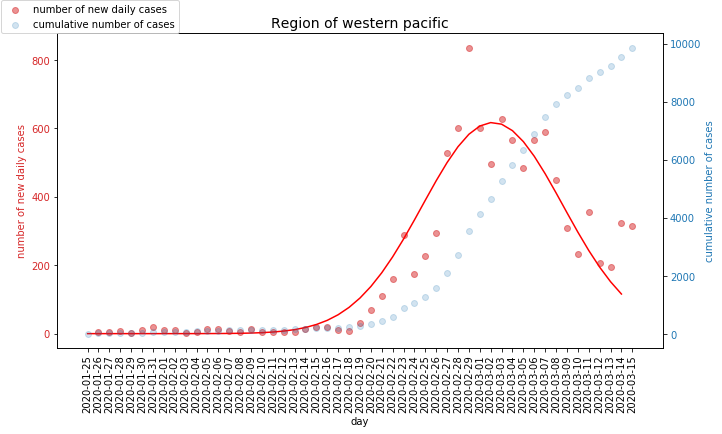

rsquare: 0.9811978421598766


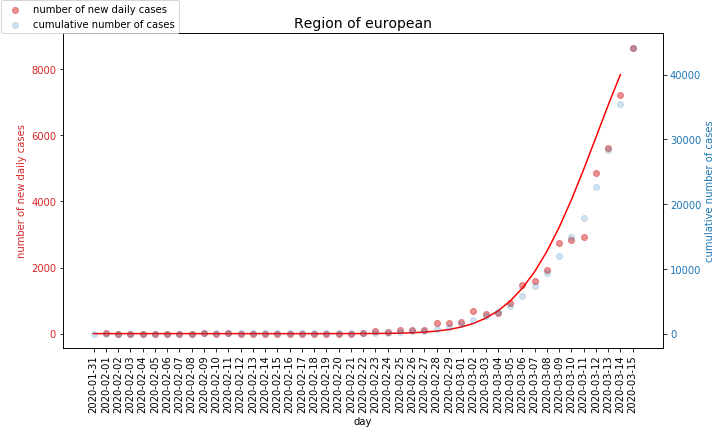

rsquare: 0.8012764767971428


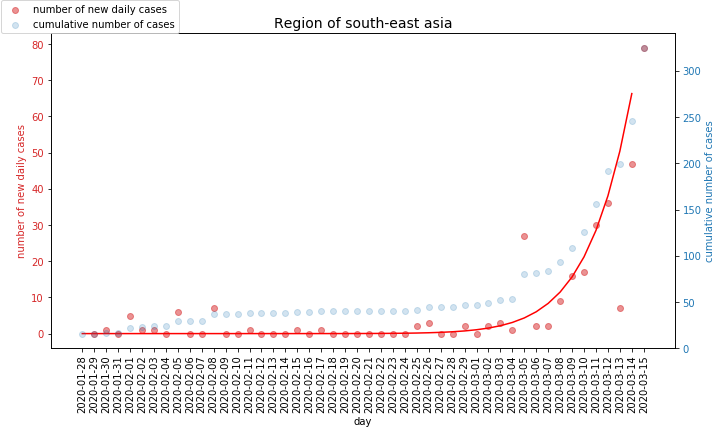

rsquare: 0.8694159088623841


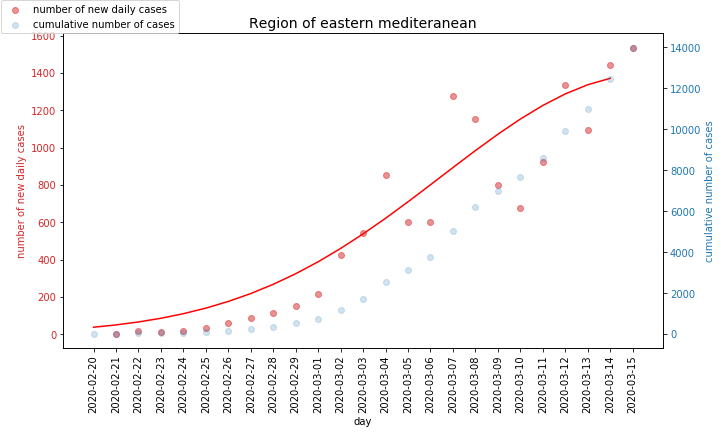

rsquare: 0.8929569232263779


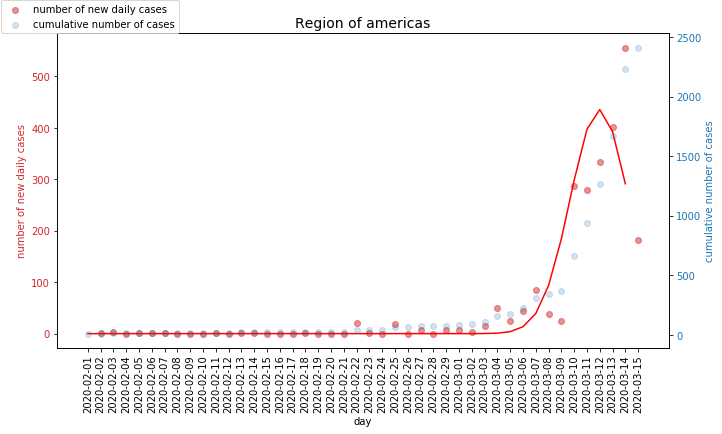

rsquare: 0.8652804300723572


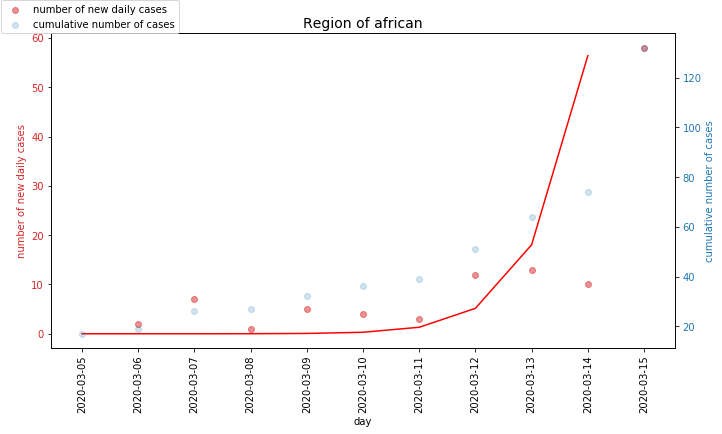

In [23]:
for region, _ in regions.items():
    df_part = df[regions[region]]
    df_part['total'] = df_part.sum(axis=1)
    df_part = df_part.loc[df_part['total']>10] #checks for at least 10 cases

    # taking derivative
    d1 = df_part['total'].diff()
    
    if region == 'china':
        d1.drop(index='2020-02-17', inplace=True)


    data1 = [d1.index, d1]
    data2 = [df_part.index, df_part['total']]

    fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
    ax1.set_title('Region of {}'.format(region), fontsize=14)

    color = 'tab:red'
    ax1.set_xlabel('day')
    ax1.set_ylabel('number of new daily cases', color=color)
    ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
    ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
    ax2.tick_params(axis='y', labelcolor=color)

    # SVR poly kernel on the second derivative
    dd1 = d1.reset_index(drop=True)
    dd1 = dd1.dropna()
    X = np.array(dd1.index)
    y = np.array(dd1)



    # regression
    bounds = ([50,15,0],[10000,90,20])
    params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
    # print(params)

    # residuals
    residuals = y - fx(X,*params)
    ssres = np.sum(residuals**2)
    sstot = np.sum((y-np.mean(y))**2)
    rsquared = 1-(ssres/sstot)
    print('rsquare: {}'.format(rsquared))

    ax1.plot(fx(X,*params), c='r')
    
    fig.legend(borderaxespad=0.1, loc='upper left')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    

    
    plt.show()



rsquare: 0.7373077104565434


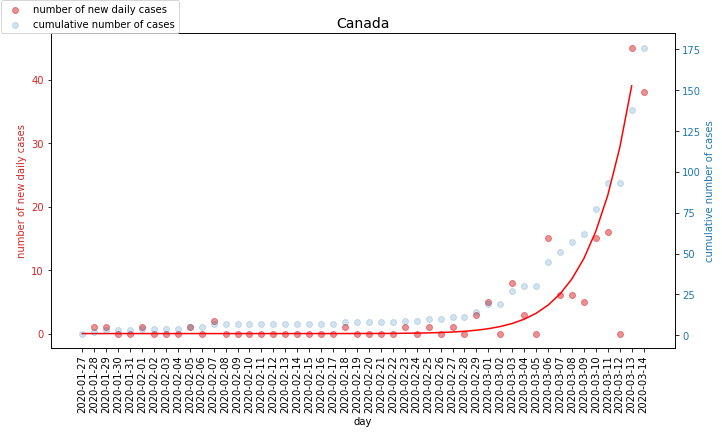

In [28]:
country = 'Canada'

df_part = df[country][:-1]
df_part = df_part.loc[df_part>0] #checks for at least 10 cases

# taking derivative
d1 = df_part.diff()

if region == 'china':
    d1.drop(index='2020-02-17', inplace=True)


data1 = [d1.index, d1]
data2 = [df_part.index, df_part]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('{}'.format(country), fontsize=14)

color = 'tab:red'
ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)



# regression
bounds = ([50,15,0],[10000,90,20])
params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
# print(params)

# residuals
residuals = y - fx(X,*params)
ssres = np.sum(residuals**2)
sstot = np.sum((y-np.mean(y))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(X,*params), c='r')

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped



plt.show()

rsquare: 0.9436264749508728


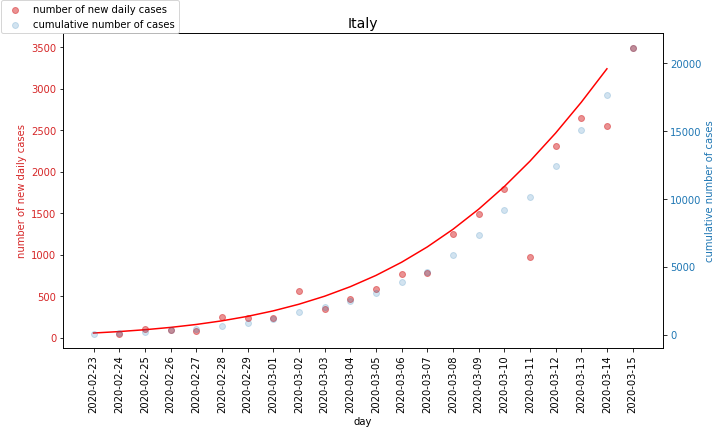

rsquare: 0.8312949475613854


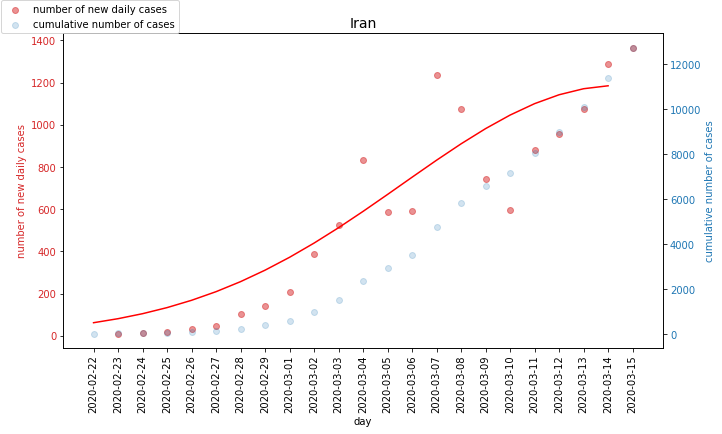

rsquare: 0.926057666377


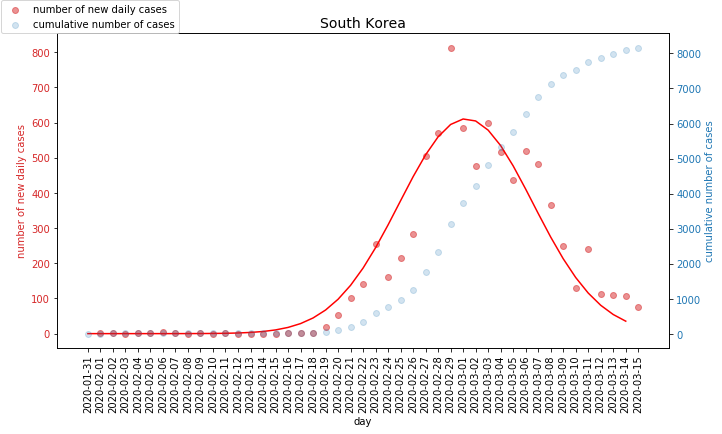

rsquare: 0.9761947669085383


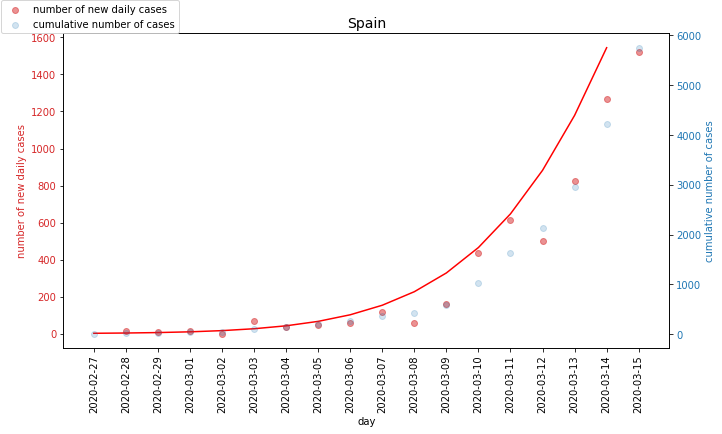

rsquare: 0.9725110664902235


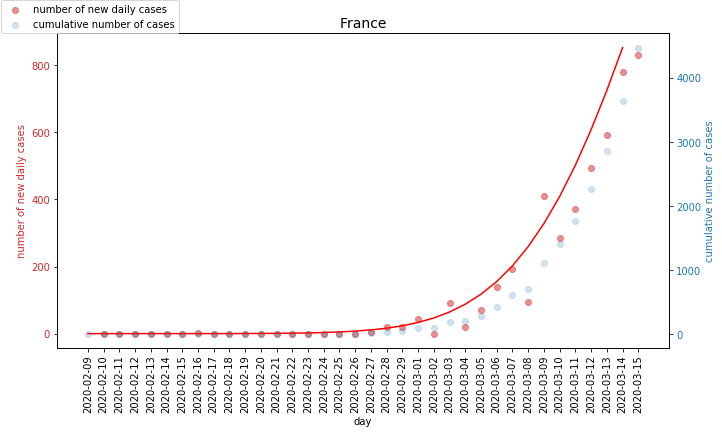

rsquare: 0.8534602843767304


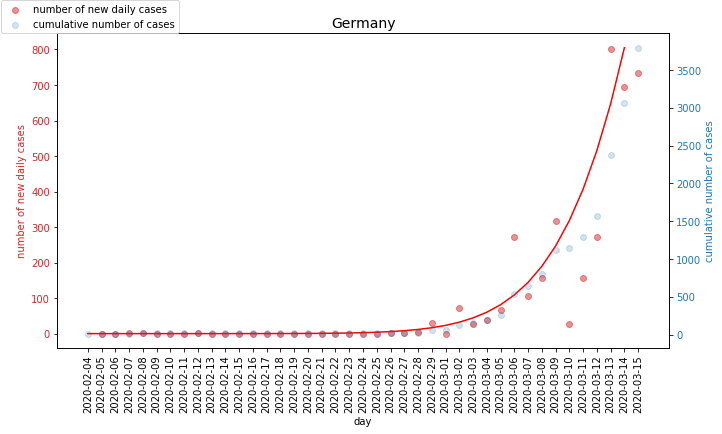

rsquare: 0.8026188605356007


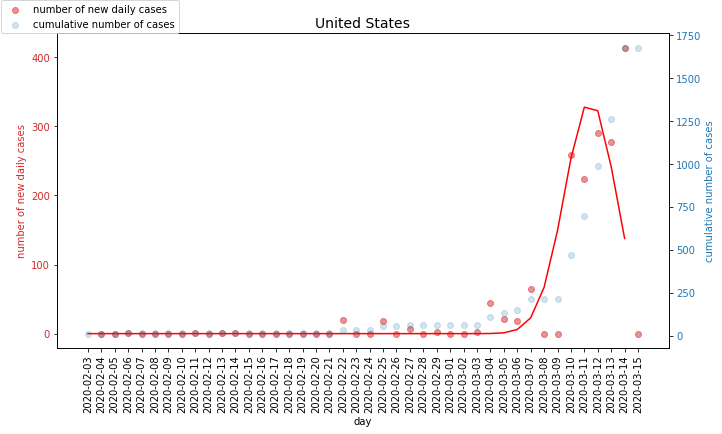

rsquare: 0.8228107531870961


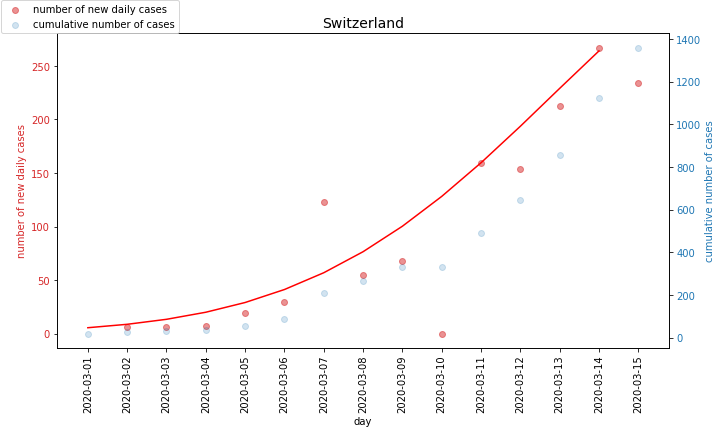

rsquare: 0.9448988298214711


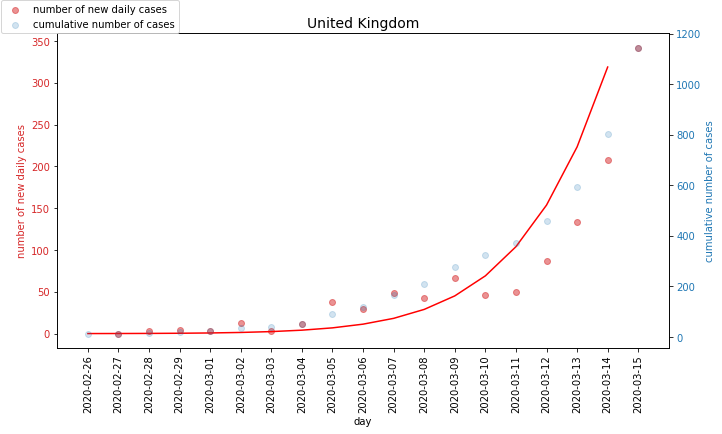

rsquare: 0.8832550707153326


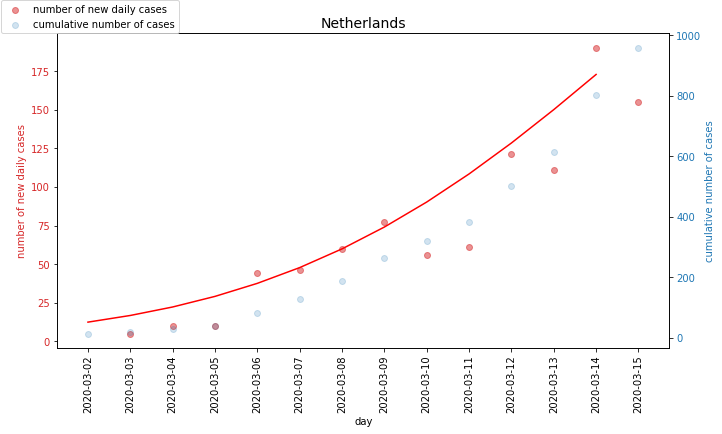

In [34]:
for country in top10:
    try:
        df_part = df[country]
        df_part = df_part.loc[df_part>10] #checks for at least 10 cases

        # taking derivative
        d1 = df_part.diff()

        if region == 'china':
            d1.drop(index='2020-02-17', inplace=True)


        data1 = [d1.index, d1]
        data2 = [df_part.index, df_part]

        fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
        ax1.set_title('{}'.format(country), fontsize=14)

        color = 'tab:red'
        ax1.set_xlabel('day')
        ax1.set_ylabel('number of new daily cases', color=color)
        ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.tick_params(axis='x', rotation=90)


        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
        ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
        ax2.tick_params(axis='y', labelcolor=color)

        # SVR poly kernel on the second derivative
        dd1 = d1.reset_index(drop=True)
        dd1 = dd1.dropna()
        X = np.array(dd1.index)
        y = np.array(dd1)



        # regression
        bounds = ([50,15,0],[10000,90,20])
        params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
        # print(params)

        # residuals
        residuals = y - fx(X,*params)
        ssres = np.sum(residuals**2)
        sstot = np.sum((y-np.mean(y))**2)
        rsquared = 1-(ssres/sstot)
        print('rsquare: {}'.format(rsquared))

        ax1.plot(fx(X,*params), c='r')

        fig.legend(borderaxespad=0.1, loc='upper left')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped



        plt.show()
    except:
        pass